# Research Agent with MCP

*The goal of research is to gather the context requested by the research brief.*

## Agent with MCP Server

We built an [agent](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) that will a custom search tool. But, we can also use the [Model Context Protocol (MCP)](https://modelcontextprotocol.io/specification/2025-06-18/architecture) as another way to access tools! MCP servers provide a standard protocol for accessing tools.

The [LangChain MCP Adapters](https://github.com/langchain-ai/langchain-mcp-adapters) provide a seamless bridge between the Model Context Protocol (MCP) and LangChain/LangGraph ecosystems. This lightweight library enables compatibility between MCP servers and our LangGraph agent. 

Let's pick one example MCP server and see how it works!

### 📁 Filesystem MCP Server

The [Filesystem MCP Server](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem) provides secure, controlled access to local file systems with granular permission management.

**What It Provides:**
- **File operations** with strict access control
- **Directory management** with dynamic permissions
- **Search capabilities** across allowed directories
- **Metadata access** for files and directories

**Available Tools:**
- **File Operations**: `read_file`, `write_file`, `edit_file`, `read_multiple_files`
- **Directory Management**: `create_directory`, `list_directory`, `move_file`
- **Search & Discovery**: `search_files`, `get_file_info`, `list_allowed_directories`

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

In [2]:
from rich.markdown import Markdown
from deep_research_from_scratch.prompts import research_agent_prompt_with_mcp
Markdown(research_agent_prompt_with_mcp)

You are a research assistant with access to local file system tools through MCP (Model Context Protocol). Your role
is to help users conduct thorough research by systematically accessing and analyzing local documents.              

CRITICAL SECURITY STEP: 🔒 ALWAYS start by calling list_allowed_directories to check what directories you can      
access. This is a security requirement that prevents access errors.                                                

AVAILABLE TOOLS: You have access to filesystem tools that can:                                                     

 • list_allowed_directories: Returns directories you can access (CALL THIS FIRST!)                                 
 • list_directory: List files and directories in the research documents folder                                     
 • read_file: Read the complete contents of specific files                                                         
 • read_multiple_files: Read multiple files simultaneously (more efficient)                                        
 • search_files: Search for files containing specific content                                                      
 • get_file_info: Get metadata about files (size, modification date, etc.)                                         

SECURE RESEARCH METHODOLOGY:                                                                                       

 1 FIRST - Check permissions: Use list_allowed_directories to see what you can access                              
 2 Then explore: Use list_directory to see available files in allowed directories                                  
 3 Read strategically: Only read files that are relevant to the user's request                                     
 4 Read each file ONCE: Don't repeatedly read the same file - remember the content                                 
 5 Use efficient tools: Use read_multiple_files when you need multiple files                                       
 6 Be targeted: Focus on files that match the user's specific needs                                                

AVAILABLE FILES (typically): Based on the expected directory structure, you should find:                           

 • coffee_shops_sf.md: Contains information about San Francisco coffee shops                                       
 • reasoning.md: Contains reasoning or methodology content                                                         

RESPONSE OPTIMIZATION:                                                                                             

 • ALWAYS start with list_allowed_directories                                                                      
 • Then use list_directory to confirm available files                                                              
 • Clearly identify which files are relevant to the user's request                                                 
 • Read only the necessary files for the specific question                                                         
 • Avoid reading all files if only one is needed                                                                   
 • Cite file names when referencing information                                                                    
 • Provide focused answers based on the relevant content                                                           

EXAMPLE WORKFLOW:                                                                                                  

 1 Call list_allowed_directories (security check)                                                                  
 2 Call list_directory on allowed directory                                                                        
 3 For coffee shop questions → Read coffee_shops_sf.md                                                             
 4 For methodology questions → Read reasoning.md                                                                   
 5 For general questions → Determine which fil

### Research Tool

Now, we'll use the `Filesystem MCP Server` to access research tools.

When using MCP tools with LangChain, you must use async methods because the MCP protocol is inherently asynchronous:
- Server communication uses async JSON-RPC over stdio/http
- Tool invocations involve network/IPC calls that can be slow
- Async enables non-blocking, concurrent operations

With this in mind, LangChain MCP Adapters are designed for async-only operation:
- Tools are wrapped as async StructuredTools
- Sync invocation is intentionally not implemented
- This ensures consistent async behavior across all MCP tools

Async enables:
- Concurrent tool execution
- Non-blocking server communication
- Better resource utilization
- Responsive applications

MCP servers run as subprocesses:
- Communication happens over pipes (stdin/stdout)
- These I/O operations are naturally async
- Blocking sync calls would freeze the entire process


In [3]:
# Simple MCP Example
import os
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.chat_models import init_chat_model

# Get the absolute path to our sample research docs
sample_docs_path = os.path.abspath("./files/")
print(f"Sample docs path: {sample_docs_path}")

# Check if the directory exists
if os.path.exists(sample_docs_path):
    print(f"Directory exists with files: {os.listdir(sample_docs_path)}")
else:
    print("Directory does not exist!")

# MCP Client configuration - filesystem server for local document access
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",  # Auto-install if needed
            "@modelcontextprotocol/server-filesystem",
            sample_docs_path
        ],
        "transport": "stdio"
    }
}

print("Creating MCP client...")
client = MultiServerMCPClient(mcp_config)
print("MCP client created successfully!")

# Test getting tools
print("Getting tools...")
tools = await client.get_tools()
print(f"Successfully got {len(tools)} tools:")
for tool in tools:
    print(f"  - {tool.name}: {tool.description}")

Sample docs path: /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files
Directory exists with files: ['reasoning.md', 'coffee_shops_sf.md']
Creating MCP client...
MCP client created successfully!
Getting tools...
Successfully got 12 tools:
  - read_file: Read the complete contents of a file from the file system. Handles various text encodings and provides detailed error messages if the file cannot be read. Use this tool when you need to examine the contents of a single file. Use the 'head' parameter to read only the first N lines of a file, or the 'tail' parameter to read only the last N lines of a file. Only works within allowed directories.
  - read_multiple_files: Read the contents of multiple files simultaneously. This is more efficient than reading files one by one when you need to analyze or compare multiple files. Each file's content is returned with its path as a reference. Failed reads for individual files won't stop the entire operation. Only works within allowed

### Agent

Now, we'll define our agent again. But, we'll include the MCP server! 

In [25]:
%%writefile ../src/deep_research_from_scratch/research_agent_mcp.py

import os
import asyncio
import nest_asyncio
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage
from typing_extensions import Literal
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.chat_models import init_chat_model
from IPython.display import Image, display

# Enable nested event loops for Jupyter
nest_asyncio.apply()

# Import our custom tool and utilities
from deep_research_from_scratch.utils import tavily_search
from deep_research_from_scratch.prompts import research_agent_prompt_with_mcp

# Using our custom @tool decorator with raw Tavily API and MCP server
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",  # Auto-install if needed
            "@modelcontextprotocol/server-filesystem",
             os.path.abspath("./files/")
        ],
        "transport": "stdio"
    }
}

# Create the MCP client
client = MultiServerMCPClient(mcp_config)

# Nodes
async def llm_call(state: MessagesState):

    # Combine the MCP tools with our custom tool
    mcp_tools = await client.get_tools()
    # tools = [tavily_search] + mcp_tools
    tools = mcp_tools
    tools_by_name = {tool.name: tool for tool in tools}

    # Initialize model
    model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")
    model_with_tools = model.bind_tools(tools)

    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(content=research_agent_prompt_with_mcp)
                ]
                + state["messages"]
            )
        ]
    }
    
def tool_node(state: dict):
    """Performs the tool call - handles async tools concurrently in Jupyter"""
    tool_calls = state["messages"][-1].tool_calls
    
    async def execute_tools():

        # Combine the MCP tools with our custom tool
        mcp_tools = await client.get_tools()
        # tools = [tavily_search] + mcp_tools
        tools = mcp_tools
        tools_by_name = {tool.name: tool for tool in tools}

        # Create coroutines for all tool calls
        coros = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call["name"]]
            coros.append(tool.ainvoke(tool_call["args"]))
        
        # Execute all tool calls concurrently
        observations = await asyncio.gather(*coros)
        
        # Create tool message outputs
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for observation, tool_call in zip(observations, tool_calls)
        ]
        
        return tool_outputs
    
    # Run async function in sync context with nested event loop support
    messages = asyncio.run(execute_tools())
    return {"messages": messages}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", "__end__"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "environment"
    # Otherwise, we stop (reply to the user)
    return "__end__"

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "environment": "environment",
        "__end__": END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_mcp.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


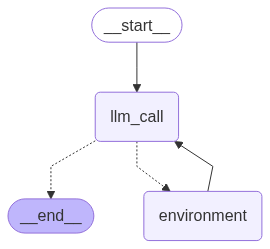

In [28]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image, display
from deep_research_from_scratch.research_agent_mcp import agent

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [29]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await agent.ainvoke({"messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research the best coffee shops in San Francisco based on coffee quality. Let me start by          │
│ exploring the available directories and files to find relevant research data.                                   │
│                                                                                                                 │
│ 🔧 Tool Call: list_allowed_directories                                                                          │
│    Args: {}                                                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: list_allowed_directories                                                                          │
│    Args: {}                                                                                                     │
│    ID: toolu_011qM6VFVpCfumxeN9ih7LqQ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Allowed directories:                                                                                            │
│ /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files"                                  │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files"                                  │
│ }                                                                                                               │
│    ID: toolu_019uAjqhEGhKrBQbwK9sethJ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ [FILE] coffee_shops_sf.md                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! I found a file specifically about San Francisco coffee shops. Let me read this file to gather          │
│ comprehensive information about the best coffee shops based on coffee quality.                                  │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files/coffee_shops_sf.md"               │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files/coffee_shops_sf.md"               │
│ }                                                                                                               │
│    ID: toolu_01XKPRXaADjjnKpUKjengqSA                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # San Francisco Coffee Shops Research                                                                           │
│                                                                                                                 │
│ ## Top Coffee Shops in San Francisco                                                                            │
│                                                                                                                 │
│ ### Blue Bottle Coffee                                                                                          │
│ - **Founded**: 2002 in Oakland, expanded to SF                                                                  │
│ - **Specialty**: Single-origin coffee, pour-over methods                                                        │
│ - **Notable**: Known for freshly roasted beans, minimalist aesthetic                                            │
│ - **Locations**: Multiple SF locations including Ferry Building                                                 │
│                                                                                                                 │
│ ### Philz Coffee                                                                                                │
│ - **Founded**: 2003 in San Francisco                                                                            │
│ - **Specialty**: Custom blended coffee, personalized service                                                    │
│ - **Notable**: Founded by Phil Jaber, known for unique blends like "Tesora"                                     │
│ - **Locations**: Original location in Mission District, now citywide                                            │
│                                                                                                                 │
│ ### Sightglass Coffee                                                                                           │
│ - **Founded**: 2009                                                                                             │
│ - **Specialty**: Third-wave coffee, roasting transparency                                                       │
│ - **Notable**: Large roastery with viewing windows, industrial aesthetic                                        │
│ - **Location**: SOMA district flagship location                                                                 │
│                                                                                                                 │
│ ### Ritual Coffee Roasters                                                                                      │
│ - **Founded**: 2005                                                                                             │
│ - **Specialty**: Direct trade relationships, seasonal offerings                                                 │
│ - **Notable**: Pioneer in San Francisco's third-wave coffee movement                                            │
│ - **Locations**: Multiple locations including Castro and Mission                                                │
│                                                                                                                 │
│ ### Four Barrel Coffee                                                                                          │
│ - **Founded**: 2008                                                                                             │
│ - **Specialty**: Small-batch roasting, community focus                                                          │
│ - **Notable**: Known for Valencia Street location, local institution                                            │
│ - **Location**: Mission District                                                                                │
╰────────────────────────────────────────────────────────

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The file provides basic information about several coffee shops, but I need more detailed information about      │
│ coffee quality assessments. Let me search for any additional files that might contain more detailed quality     │
│ evaluations or reviews.                                                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files",                                 │
│   "pattern": "coffee"                                                                                           │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files",                                 │
│   "pattern": "coffee"                                                                                           │
│ }                                                                                                               │
│    ID: toolu_01GXDzL5H9fM49WPoMUcaCw4                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files/coffee_shops_sf.md                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the available research file, I can provide you with a comprehensive analysis of the top coffee shops   │
│ in San Francisco, focusing on coffee quality. Here's my evaluation based on the data:                           │
│                                                                                                                 │
│ ## Top San Francisco Coffee Shops Ranked by Coffee Quality                                                      │
│                                                                                                                 │
│ ### 1. **Blue Bottle Coffee** (Est. 2002)                                                                       │
│ **Coffee Quality Indicators:**                                                                                  │
│ - **Specialty Focus**: Single-origin coffee and pour-over methods                                               │
│ - **Freshness Standard**: Known specifically for freshly roasted beans                                          │
│ - **Third-Wave Pioneer**: One of the early adopters of artisanal coffee culture                                 │
│ - **Quality Assessment**: Emphasis on pour-over methods indicates commitment to brewing technique excellence    │
│ - **Multiple Locations**: Ferry Building and other SF locations                                                 │
│                                                                                                                 │
│ ### 2. **Ritual Coffee Roasters** (Est. 2005)                                                                   │
│ **Coffee Quality Indicators:**                                                                                  │
│ - **Direct Trade Relationships**: Ensures quality control from source                                           │
│ - **Seasonal Offerings**: Indicates commitment to peak coffee seasons and quality                               │
│ - **Third-Wave Movement Pioneer**: Established leader in San Francisco's specialty coffee scene                 │
│ - **Quality Focus**: Direct trade model typically correlates with higher quality beans                          │
│ - **Locations**: Castro and Mission districts                                                                   │
│                                                                                                                 │
│ ### 3. **Sightglass Coffee** (Est. 2009)                                                                        │
│ **Coffee Quality Indicators:**                                                                                  │
│ - **Third-Wave Coffee Specialist**: Focus on artisanal preparation methods                                      │
│ - **Roasting Transparency**: Large roastery with viewing windows demonstrates commitment to process             │
│ transparency                                                                                                    │
│ - **Quality Control**: Visible roasting process suggests confidence in their methods                            │
│ - **SOMA Flagship**: Significant investment in flagship location indicates quality focus                        │
│                                                                                                                 │
│ ### 4. **Four Barrel Coffee** (Est. 2008)                                                                       │
│ **Coffee Quality Indicators:**                                                                                  │
│ - **Small-Batch Roasting**: Indicates attention to detail and quality control                                   │
│ - **Community Institution**: Local reputation suggests consistent quality                                       │
│ - **Mission District Location**: Positioned in SF's cof

### What Just Happened? Let's Understand Each Component

#### The Client-Server Architecture

**Basic Client-Server Model:**
- **Client**: The `MultiServerMCPClient` acts as the client that requests services
- **Server**: The MCP server provides tools and executes operations
- **Communication**: They communicate using a standardized protocol (MCP)

```python
client = MultiServerMCPClient(mcp_config)
```

The `MultiServerMCPClient` is our LangChain MCP adapter client that:
- Starts MCP servers based on configuration
- Manages communication with one or more servers
- Converts MCP protocols to LangChain-compatible formats

#### `mcp_config` Dictionary and Transport Types

The configuration tells the MCP client how to start and connect to MCP servers:

```python
mcp_config = {
    "filesystem": {  # Server name (arbitrary label)
        "command": "npx",  # Command to run
        "args": ["-y", "@modelcontextprotocol/server-filesystem", "/path/to/docs"],
        "transport": "stdio"  # Communication method
    }
}
```

**Configuration Components:**
- **Server name** (`"filesystem"`): An arbitrary label for this server instance
- **Command** (`"npx"`): The command to execute to start the server
- **Args**: Command-line arguments passed to the server
- **Transport**: How the client communicates with the server

**Two Transport Types:**

1. **stdio Transport** (Local Servers):
   - Uses standard input/output for communication
   - Server runs as a subprocess on your local machine
   - Communication via pipes (stdin/stdout)
   - Example: `"transport": "stdio"`

2. **HTTP Transport** (Remote Servers):
   - Uses HTTP requests for communication
   - Server runs remotely on another machine/service
   - Communication via HTTP endpoints
   - Example: `"transport": "http"` with `"url": "https://api.example.com/mcp"`

**Remote MCP Servers:**
Remote MCP servers are third-party services that provide tools via HTTP. According to [Anthropic's documentation](https://docs.anthropic.com/en/docs/agents-and-tools/remote-mcp-servers):

- Companies like Asana, Cloudflare, PayPal, and Zapier offer remote MCP servers
- These use HTTP transport instead of stdio
- Typical URL format: `https://mcp.[company-name].com/sse`
- Require authentication credentials and trust verification

**Example Remote Configuration:**
```python
mcp_config = {
    "remote_service": {
        "url": "https://mcp.example.com/sse",
        "transport": "http",
        "headers": {
            "Authorization": "Bearer your-token-here"
        }
    }
}
```

#### The Server

When using stdio transport (local servers):
- Client `MultiServerMCPClient(mcp_config)` starts the server as a subprocess
- Server is a Node.js process running on your local machine
- It runs: `npx @modelcontextprotocol/server-filesystem /path/to/docs`
- The server process runs as long as the client is active
- **Verified**: Yes, the client starts and manages the server process lifecycle

When using HTTP transport (remote servers):
- Client connects to an existing remote server
- No subprocess is started locally
- Server runs independently on remote infrastructure
- Communication happens over HTTP/HTTPS

#### Tool Binding

Within the agent, MCP client queries the server for tools:
```python
tools = await client.get_tools()
```

**The Process:**
1. MCP client queries each server: "What tools do you provide?"
2. Server responds with tool metadata: Name, description, parameters, types
3. The MCP client (adapter) converts tool metadata to LangChain format
4. This makes them compatible with LangChain agents
5. We bind the tools to the model as usual:
```python
model_with_tools = model.bind_tools(tools)
```

#### Tool Execution

When the LLM calls a tool:
1. **LLM Decision**: The LLM decides which tools to use based on the user's request
2. **Tool Invocation**: We invoke the tool in the tool node
3. **Client Forwarding**: The client forwards the request to the appropriate server
4. **Communication**: 
   - **stdio**: Via STDIN (for local servers)
   - **HTTP**: Via HTTP requests (for remote servers)
5. **Server Execution**: The server executes the operation (e.g., reads a file)
6. **Async Processing**: This is done asynchronously for performance
7. **Response**: Server sends responses back to the client
   - **stdio**: Via STDOUT (for local servers)
   - **HTTP**: Via HTTP responses (for remote servers)
8. **Protocol**: All communication uses MCP protocol format (JSON-RPC)

```python
coros.append(tool.ainvoke(tool_call["args"]))
```

**Key Differences:**
- **Local (stdio)**: Fast, secure, requires server installation
- **Remote (HTTP)**: Slower, requires trust/auth, no local installation needed

## Lesson

In this notebook, we tested a single filesystem server running locally. 

Have a look at [other servers](https://modelcontextprotocol.io/examples). 

Try a few out! Also consider remote servers! 